In [17]:
import numpy as np
import pandas as pd
import nltk
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('IMDB Dataset.csv')

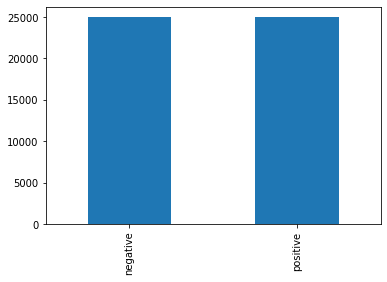

In [3]:
data.sentiment.value_counts().plot.bar()
plt.show()

# Text preprocessing

In [4]:
stop = nltk.corpus.stopwords.words('english')

In [5]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub(pattern,'',text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
        
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [6]:
data['review'] = data['review'].apply(normalise_text)

In [7]:
data['review'] = data['review'].apply(remove_special_characters)

In [8]:
data['review'] = data['review'].apply(remove_stopwords)

In [9]:
data['review'] = data['review'].apply(stemmer)

In [10]:
X = data.review
y = data.sentiment

In [11]:
seed = 42

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = seed)

In [13]:
# binarize the categorical statemnt
lb = LabelBinarizer()
train_sentiment = lb.fit_transform(y_train)
test_sentiment = lb.fit_transform(y_test)

### Metrics

In [14]:
def binary_classification_performance(y_test, y_pred, model):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall) 
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)
    model_name = model
    result = pd.DataFrame({
                         'Model' : [model_name],
                         'Accuracy':[accuracy],
                         'Precision' : [precision],
                         'Recall': [recall],
                         'f1 score' : [f1_score],
                        })
    
    return result

# BoW - tfidf

__Bag of words__ is a word representation technique that counts the occurence of words existing within documents in the corpus.


Term frequency inverted document frequency __(tfidf)__ attempts to weight the importance of a word reversely to its frequency within a document. This is attributed to the fact that highly occuring words within a document might not bear as much of contextual information as less occuring words, which could be more descriptive about the document

In [28]:
cv = CountVectorizer()
cv_train_reviews = cv.fit_transform(X_train)
cv_test_reviews = cv.transform(X_test)

tv = TfidfVectorizer()
tv_train_reviews = tv.fit_transform(X_train)
tv_test_reviews = tv.transform(X_test)

### Logistric Regression

In [29]:
lr = LogisticRegression(random_state = seed)

lr_bow = lr.fit(cv_train_reviews, train_sentiment)
lr_tfidf = lr.fit(tv_train_reviews, train_sentiment)

lr_bow_predict = lr.predict(cv_test_reviews)
lr_tfidf_predict = lr.predict(tv_test_reviews)

lr_bow_score = binary_classification_performance(test_sentiment, lr_bow_predict, 'Logistic Regression BoW')
lr_tfidf_score = binary_classification_performance(test_sentiment, lr_tfidf_predict, 'Logistic Regression tfidf')

### Naive Bayes

In [30]:
mnb = MultinomialNB()

mnb_bow = mnb.fit(cv_train_reviews,train_sentiment)
mnb_tfidf = mnb.fit(tv_train_reviews,train_sentiment)

mnb_bow_predict = mnb.predict(cv_test_reviews)
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

mnb_bow_score = binary_classification_performance(test_sentiment,mnb_bow_predict, 'Naive Bayes BoW')
mnb_tfidf_score = binary_classification_performance(test_sentiment,mnb_tfidf_predict, 'Naive Bayes tfidf')

# Ngrams (1,2)

__Ngrams__ are sets of continuous words found within a document. Their length can be extended by the configurable number parameter. In this case a (1,2) ngram is being selected, meaning a set of two words. Ngrams facilitate text classification as words which bear contextual meaning are matched together.

e.g; The neighbour's dog barks loudly -> {The neighbour's} - {neighbour's dog} - {dog barks} - {barks loudly}.

As seen on the example above the created ngram can be more representive about a text.

In [31]:
cv = CountVectorizer(ngram_range = (1,2))
cv_train_reviews = cv.fit_transform(X_train)
cv_test_reviews = cv.transform(X_test)

In [32]:
tv = TfidfVectorizer(ngram_range = (1,2))
tv_train_reviews = tv.fit_transform(X_train)
tv_test_reviews = tv.transform(X_test)

### Logistic Regression

In [33]:
lr = LogisticRegression(random_state = seed)

lr_bow = lr.fit(cv_train_reviews, train_sentiment)
lr_tfidf = lr.fit(tv_train_reviews, train_sentiment)

lr_bow_predict = lr.predict(cv_test_reviews)
lr_tfidf_predict = lr.predict(tv_test_reviews)

lr_bow_score_ngram = binary_classification_performance(test_sentiment, lr_bow_predict, 'Logistic Regression BoW ngram')
lr_tfidf_score_ngram = binary_classification_performance(test_sentiment, lr_tfidf_predict, 'Logistic Regression tfidf ngram')

### Naive Bayes 

In [34]:
mnb = MultinomialNB()
mnb_bow = mnb.fit(cv_train_reviews,train_sentiment)
mnb_tfidf = mnb.fit(tv_train_reviews,train_sentiment)

mnb_bow_predict = mnb.predict(cv_test_reviews)
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

mnb_bow_score_ngram = binary_classification_performance(test_sentiment,mnb_bow_predict, 'Naive Bayes BoW ngram')
mnb_tfidf_score_ngram = binary_classification_performance(test_sentiment,mnb_tfidf_predict, 'Naive Bayes tfidf ngram')

# Model comparison

In [35]:
dfs = (lr_bow_score, lr_tfidf_score, mnb_bow_score, mnb_tfidf_score, 
       lr_bow_score_ngram, lr_tfidf_score_ngram, mnb_bow_score_ngram, mnb_tfidf_score_ngram)

In [36]:
test = pd.concat(dfs)

In [38]:
test.set_index('Model').sort_values('Accuracy', ascending = False)

,Accuracy,Precision,Recall,f1 score
Model,,,,
Logistic Regression tfidf,0.889030,0.879033,0.903521,0.891109
Logistic Regression tfidf ngram,0.886788,0.875058,0.903763,0.889179
Naive Bayes tfidf ngram,0.884182,0.895108,0.871684,0.883241
Naive Bayes BoW ngram,0.875515,0.902140,0.843825,0.872009
Logistic Regression BoW,0.867818,0.840749,0.909190,0.873631
Logistic Regression BoW ngram,0.863212,0.849450,0.884588,0.866663
Naive Bayes tfidf,0.857333,0.867450,0.845273,0.856218
Naive Bayes BoW,0.855333,0.893929,0.808008,0.848800
